# Dark Matter Halo
## Preamble

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
from IPython.display import Latex

# comment out the following lines if seaborn is not installed
#import seaborn as sns
#sns.set(rc={'text.usetex' : True})
#sns.set_context("paper", font_scale=2)
#sns.set_style("ticks", {'axes.grid': False,
#                        'axes.linewidth': 1.5,
#                        'legend.frameon':True,
#                        'useTex':True})

## Units and Constants

In [2]:
GeV  = 1.
s    = 1.
cm   = 1.
km   = 1.e5*cm
m    = 1.e2*cm
pc   = 3.086e18*cm
kpc  = 1e3*pc
Mpc  = 1.e6*pc
Msun = 1.11575e57*GeV
rad  = np.pi/180.

#DM density
Omega_m = 0.32 #assuming constant DM density in the Milky Way

#cutoff parameter for halo definition
delta_vir = 18*np.pi**2+82*(Omega_m-1)-39*(Omega_m-1)**2
#without the correction from DM abundance
#delta_vir = 18*np.pi**2

#halo concentration
c_vir = 10

#mass of the Milky Way halo
M = 10**12*Msun

#Hubble constant
H_0 = 70*km/(s*Mpc)

#gravitational constant
G = 4.30091*10**-3*pc*Msun**-1*(km/s)**2

#critical density
rho_c = H_0**2*3/(8*np.pi*G)

#virial radius
r_vir = (3*M/(4*np.pi*delta_vir*rho_c))**(1/3)

#distance of Earth from the galactic center
d = 8.122*kpc

## Estimates for $r_s$ and $\rho_s$

In [3]:
r_s = r_vir/c_vir

rho_s = M/(4*np.pi*r_s**3*(np.log(1+c_vir)-c_vir/(1+c_vir)))

display(Latex(r'We find that, for the Milky Way halo, '+
              '$r_s='+str(round(r_s/kpc,1))+'$ kpc and '+
              '$\\rho_s='+str(round(rho_s,2))+'$ GeV$/$cm$^3$'+
              ', but we will proceed with calculations using given values.'))

r_s = 20.*kpc

rho_s = 0.3

<IPython.core.display.Latex object>

## Calculations

In [4]:
def rho_DM(r):
    """
    Returns DM density following NFW profile
    """
    return rho_s/((r/r_s)*((r/r_s)+1)**2)


def radius(l, psi, theta, deg=True):
    """
    Returns radius measured from GC as function of:
     - l: distance from Earth
     - psi: longitude
     - theta: latitude
     
     If psi and theta are in degrees, they will be
     converted to rads if "deg=True"
     """
    if deg:
        psi = psi*rad
        theta = theta*rad
    return np.sqrt(d**2+l**2-2*d*l*np.cos(psi)*np.cos(theta))


def dJ_dOmega(psi, theta, N=10**3, deg=True):
    """
    Returns differential J-factor as a function of psi and theta
    This is done by integrating along line of sight
    N is the number of cells used in the calculation
    """
    l_0 = 0.
    l_f = 500.*kpc
    dl = (l_f - l_0)/N
    # create array of midpoints
    l_mids = np.linspace(dl/2, l_f-dl/2., N)
    rs = radius(l_mids, psi, theta, deg)
    s = np.sum(rho_DM(rs)**2.)
    return s*dl

def J_GC(n=100):
    """
    Returns J-factor around GC
    Integrates over a circle with radius 0.5 degree
    """
    psi_0 = -0.5
    psi_f = 0.5
    dpsi = (psi_f - psi_0)/n
    psi_vect = np.linspace(psi_0, psi_f, n)
    theta_vect = psi_vect
    
    J_vect = np.zeros((n,n))
    
    for i in range(len(psi_vect)):
        for j in range(len(theta_vect)):
            J_vect[i,j] = dJ_dOmega(psi_vect[i],theta_vect[j],deg=True)
    
    xx, yy = np.meshgrid(psi_vect, theta_vect, sparse=True)
    dist = np.sqrt(xx**2 + yy**2)
    
    return np.mean(J_vect[dist<0.5])


display(Latex(r'We find that '+
              '$J='+str(round(J_GC()*10**-24,1))+'\\times 10^{24}$ GeV$^2/$cm$^5$'+
              ' for a circle of radius $0.5$ degrees around the galactic center.'))

<IPython.core.display.Latex object>

## Plotting

### NFW Profile

/home/anders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


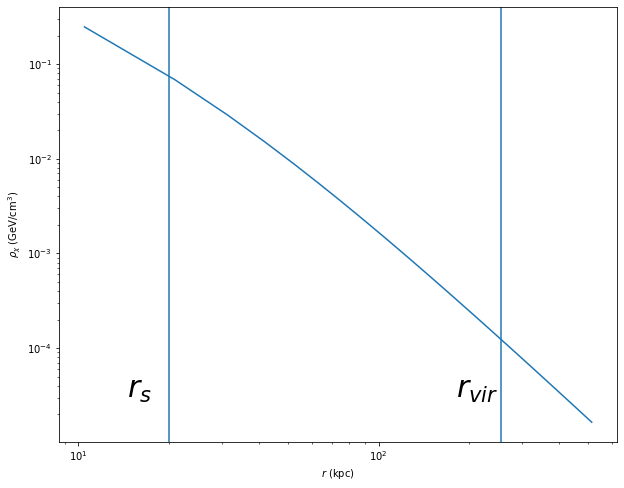

In [5]:
rs = np.linspace(0, 2*r_vir)

plt.figure(figsize=(10,8))
plt.plot(rs/kpc, rho_DM(rs))
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\rho_\chi$ (GeV$/$cm$^3$)')
plt.xlabel(r'$r$ (kpc)')
plt.axvline(r_s/kpc)
plt.text(r_s/kpc-5.5,3e-5,r'$r_s$',fontsize=30)
plt.axvline(r_vir/kpc)
plt.text(r_vir/kpc-75,3e-5,r'$r_{vir}$',fontsize=30)
plt.show()

### Differential $J$-factor as a function of angle $\psi$

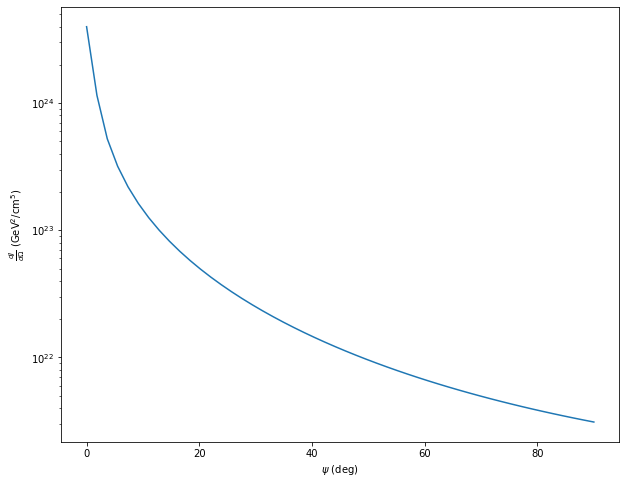

In [6]:
psis = np.linspace(0, 90, num=50)
dJ_dOmega_vect = []
for psi in psis:
    dJ_dOmega_vect.append(dJ_dOmega(psi,0))
    
plt.figure(figsize=(10,8))
plt.plot(psis, dJ_dOmega_vect,0)
plt.yscale('log')
plt.xscale('linear')
plt.ylabel(r'$\frac{dJ}{d\Omega}$ (GeV$^2/$cm$^5$)')
plt.xlabel(r'$\psi$ (deg)')
plt.show()

### Convergence Tests

In [7]:
tests = False  # change to True to display plots

if tests:
    Ns = np.logspace(1, 3, num = 10)
    dJ_dOmega_vect = []
    for N in Ns:
        dJ_dOmega_vect.append(dJ_dOmega(1.0, 1.0, int(N), deg=False))
    plt.figure(figsize=(10,8))
    plt.plot(Ns, dJ_dOmega_vect)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$\frac{dJ}{d\Omega}$')
    plt.xlabel('Number of cells')
    plt.title(r"Convergence Test of $\frac{dJ}{d\Omega}$ for $\psi=1$ rad and $\theta=1$ rad")
    plt.show()
    
    Ns = np.logspace(1, 3, num = 5)
    J_vect = []
    for N in Ns:
        J_vect.append(J_GC(int(N)))
    plt.figure(figsize=(10,8))
    plt.plot(Ns, J_vect)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel(r'$J$-factor')
    plt.xlabel('Square root of the number of cells')
    plt.title(r"Convergence Test of $J$-factor")
    plt.show()